Reference - this code is just modification of https://github.com/dennybritz/reinforcement-learning

In [1]:
%run ../utils/commonImports.py
%run ../utils/tradingImports.py
%matplotlib inline

In [2]:
import gym
import itertools
import matplotlib
import numpy as np
import sys
import tensorflow as tf
import collections

matplotlib.style.use('ggplot')

In [3]:
from copy import deepcopy

In [4]:
from collections import namedtuple
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

EpisodeStats = namedtuple("Stats",["episode_lengths", "episode_rewards"])

def plot_cost_to_go_mountain_car(env, estimator, num_tiles=20):
    x = np.linspace(env.observation_space.low[0], env.observation_space.high[0], num=num_tiles)
    y = np.linspace(env.observation_space.low[1], env.observation_space.high[1], num=num_tiles)
    X, Y = np.meshgrid(x, y)
    Z = np.apply_along_axis(lambda _: -np.max(estimator.predict(_)), 2, np.dstack([X, Y]))

    fig = plt.figure(figsize=(10, 5))
    ax = fig.add_subplot(111, projection='3d')
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                           cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
    ax.set_xlabel('Position')
    ax.set_ylabel('Velocity')
    ax.set_zlabel('Value')
    ax.set_title("Mountain \"Cost To Go\" Function")
    fig.colorbar(surf)
    plt.show()


def plot_value_function(V, title="Value Function"):
    """
    Plots the value function as a surface plot.
    """
    min_x = min(k[0] for k in V.keys())
    max_x = max(k[0] for k in V.keys())
    min_y = min(k[1] for k in V.keys())
    max_y = max(k[1] for k in V.keys())

    x_range = np.arange(min_x, max_x + 1)
    y_range = np.arange(min_y, max_y + 1)
    X, Y = np.meshgrid(x_range, y_range)

    # Find value for all (x, y) coordinates
    Z_noace = np.apply_along_axis(lambda _: V[(_[0], _[1], False)], 2, np.dstack([X, Y]))
    Z_ace = np.apply_along_axis(lambda _: V[(_[0], _[1], True)], 2, np.dstack([X, Y]))

    def plot_surface(X, Y, Z, title):
        fig = plt.figure(figsize=(20, 10))
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1,
                               cmap=matplotlib.cm.coolwarm, vmin=-1.0, vmax=1.0)
        ax.set_xlabel('Player Sum')
        ax.set_ylabel('Dealer Showing')
        ax.set_zlabel('Value')
        ax.set_title(title)
        ax.view_init(ax.elev, -120)
        fig.colorbar(surf)
        plt.show()

    plot_surface(X, Y, Z_noace, "{} (No Usable Ace)".format(title))
    plot_surface(X, Y, Z_ace, "{} (Usable Ace)".format(title))



def plot_episode_stats(stats, smoothing_window=10, noshow=False):
    # Plot the episode length over time
    fig1 = plt.figure(figsize=(10,5))
    plt.plot(stats.episode_lengths)
    plt.xlabel("Episode")
    plt.ylabel("Episode Length")
    plt.title("Episode Length over Time")
    if noshow:
        plt.close(fig1)
    else:
        plt.show(fig1)

    # Plot the episode reward over time
    fig2 = plt.figure(figsize=(10,5))
    rewards_smoothed = pd.Series(stats.episode_rewards).rolling(smoothing_window, min_periods=smoothing_window).mean()
    plt.plot(rewards_smoothed)
    plt.xlabel("Episode")
    plt.ylabel("Episode Reward (Smoothed)")
    plt.title("Episode Reward over Time (Smoothed over window size {})".format(smoothing_window))
    if noshow:
        plt.close(fig2)
    else:
        plt.show(fig2)

    # Plot time steps and episode number
    fig3 = plt.figure(figsize=(10,5))
    plt.plot(np.cumsum(stats.episode_lengths), np.arange(len(stats.episode_lengths)))
    plt.xlabel("Time Steps")
    plt.ylabel("Episode")
    plt.title("Episode per time step")
    if noshow:
        plt.close(fig3)
    else:
        plt.show(fig3)

    return fig1, fig2, fig3

# Load Data

In [5]:
dataRoot = 'D:\\Dropbox\\My work\\krypl-project\\dataFeatures\\poloniex\\5min'
fileName = 'USDT_BTC_5min_2016-01-01_2017-12-31.tsv'
file = '{dataRoot}\\{fileName}'.format(dataRoot=dataRoot, fileName=fileName)

usdtBtc = pd.read_csv(file, sep='\t').query("date >= '2017-01-01'")\
    .sort_values('timestamp').reset_index().drop('index', axis=1)
usdtBtc = usdtBtc

trainRatio = 0.7
trainSize = int(usdtBtc.shape[0] * trainRatio)
usdtBtcTrain = usdtBtc.iloc[:trainSize]
usdtBtcTest = usdtBtc.iloc[trainSize:].reset_index().drop('index', axis=1)

usdtBtcManagerTrain = CurrencyDataManager(usdtBtcTrain['close'], usdtBtcTrain)
usdtBtcManagerTest = CurrencyDataManager(usdtBtcTest['close'], usdtBtcTest)
wallet = {'usdt': 1000}
contractPair = ContractPair.new('usdt', 'btc')

In [6]:
dataManager = deepcopy(usdtBtcManagerTrain)
exchange = BackTestExchange(dataManager, deepcopy(wallet), 0.0025)

# Dummy Estimators

Just to test learning performance

In [7]:
class DummyPolicyEstimator:
    def predict(self, state):
        return [0.7, 0.1, 0.2] 
    
    def update(self, state, target, action):
        pass

    
class DummyValueEstimator:
    def predict(self, state):
        return 0
    
    def update(self, state, target):
        pass

# Reinforce

In [8]:
usdtBtcTrain.columns

Index(['close', 'timestamp', 'high', 'low', 'open', 'quoteVolume', 'volume',
       'weightedAverage', 'date', 'entryReturn_001', 'entryReturn_003',
       'entryReturn_006', 'entryReturn_01', 'entryReturn_03', 'entryReturn_05',
       'entryReturn_07', 'entryReturn_1', 'entryReturn_12', 'entryReturn_15',
       'entryReturn_18', 'entryReturn_2', 'entryReturn_22', 'entryReturn_25',
       'entryReturn_28', 'entryReturn_3', 'labelSlope_close_12', 'returnOpen',
       'returnClose', 'returnHigh', 'returnLow', 'labelSlope_returnClose_12',
       'return', 'return_1', 'return_2', 'zscore_36_return',
       'zscore_288_return'],
      dtype='object')

In [9]:
from modeling.rl.enviroment import ExchangeEnv
from modeling.rl.estimator import PerceptronPolicyEstimator, PerceptronValueEstimator

cols = ['close', 'return', 'return_1', 'return_2', 'zscore_36_return', 'zscore_288_return']

env = ExchangeEnv(
    data=usdtBtcTrain[cols],
    priceCol='close',
    contractPair=contractPair,
    wallet=wallet,
    fee=0.0025,
    epochLen=288,
    buyAmount=100
)

In [10]:
def getState(envState):
    return envState

In [15]:
def reinforce(env, estimator_policy, estimator_value, num_episodes, discount_factor=1.0):
    """
    REINFORCE (Monte Carlo Policy Gradient) Algorithm. Optimizes the policy
    function approximator using policy gradient.
    
    Args:
        env: OpenAI environment.
        estimator_policy: Policy Function to be optimized 
        estimator_value: Value function approximator, used as a baseline
        num_episodes: Number of episodes to run for
        discount_factor: Time-discount factor
    
    Returns:
        An EpisodeStats object with two numpy arrays for episode_lengths and episode_rewards.
    """

    # Keeps track of useful statistics
    stats = EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    Transition = collections.namedtuple("Transition", ["state", "action", "reward", "next_state", "done"])
    episodes = []
    for i_episode in range(num_episodes):
        # Reset the environment and pick the fisrst action
        state = getState(env.reset())
        episode = []
        
        # One step in the environment
        for t in itertools.count():
            
            # Take a step
            action_probs = estimator_policy.predict(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            next_state = getState(next_state)
            # Keep track of the transition
            episode.append(Transition(state=state, action=action, reward=reward, next_state=next_state, done=done))
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # Print out which step we're on, useful for debugging.
            print("\rStep {} @ Episode {}/{} ({})".format(
                    t, i_episode + 1, num_episodes, stats.episode_rewards[i_episode - 1]), end="")
            # sys.stdout.flush()

            if done:
                break
                
            state = next_state
            
        episodes.append(episode)
    
        # Go through the episode and make policy updates
        for t, transition in enumerate(episode):
            # The return after this timestep
            total_return = sum(discount_factor**i * t.reward for i, t in enumerate(episode[t:]))
            # Calculate baseline/advantage
            baseline_value = estimator_value.predict(transition.state)            
            advantage = total_return - baseline_value
            # Update our value estimator
            estimator_value.update(transition.state, total_return)
            # Update our policy estimator
            estimator_policy.update(transition.state, advantage, transition.action)
    
    return stats, episodes

In [17]:
# import cProfile, pstats, io
# pr = cProfile.Profile()
# pr.enable()


# ---- START -----


tf.reset_default_graph()

global_step = tf.Variable(0, name="global_step", trainable=False)
policy_estimator = PerceptronPolicyEstimator(env.observation_space.n, env.action_space.n)
value_estimator = PerceptronValueEstimator(env.observation_space.n)

# policy_estimator = DummyPolicyEstimator()
# value_estimator = DummyValueEstimator()

with tf.Session() as sess:
    sess.run(tf.initialize_all_variables())
    stats, episodes = reinforce(env, policy_estimator, value_estimator, 100, discount_factor=1.0)
    
# ---- END ----

# pr.disable()

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:97: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Step 286 @ Episode 100/100 (0.0)

In [13]:
stats

Stats(episode_lengths=array([ 286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,
        286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.,  286.]), episode_rewards=array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0

In [19]:
episodes[-1]

[Transition(state=array([[  4.27595902e-03,  -2.55076633e-03,  -6.05201441e-04,
          2.13785597e+00,   1.13788722e+00]]), action=1, reward=0.0, next_state=array([[-0.00485332,  0.00427596, -0.00255077, -2.33260597, -1.29158347]]), done=False),
 Transition(state=array([[-0.00485332,  0.00427596, -0.00255077, -2.33260597, -1.29158347]]), action=0, reward=0.0, next_state=array([[ 0.00140608, -0.00485332,  0.00427596,  0.64609918,  0.37311341]]), done=False),
 Transition(state=array([[ 0.00140608, -0.00485332,  0.00427596,  0.64609918,  0.37311341]]), action=1, reward=0.0, next_state=array([[ -3.76715021e-03,   1.40608302e-03,  -4.85331772e-03,
         -1.72822721e+00,  -9.97014132e-01]]), done=False),
 Transition(state=array([[ -3.76715021e-03,   1.40608302e-03,  -4.85331772e-03,
         -1.72822721e+00,  -9.97014132e-01]]), action=2, reward=0.0, next_state=array([[-0.00225405, -0.00376715,  0.00140608, -0.96392546, -0.59219708]]), done=False),
 Transition(state=array([[-0.00225405

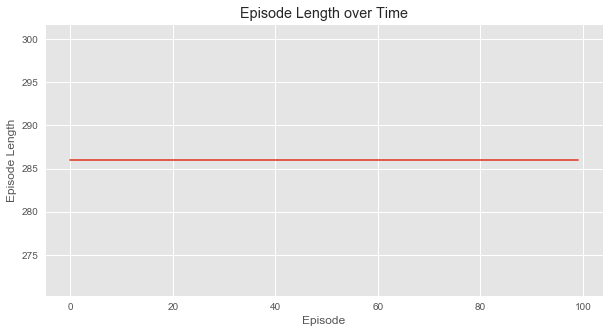

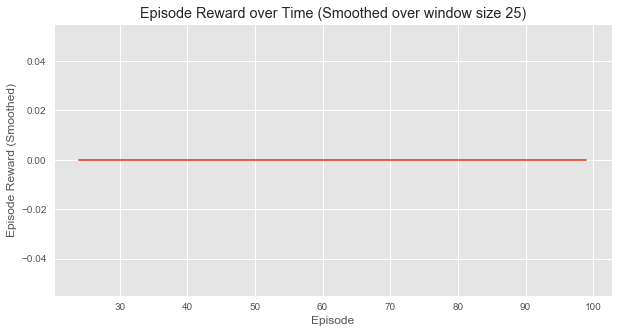

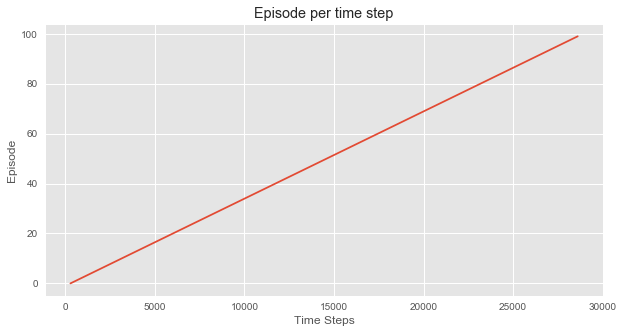

(<matplotlib.figure.Figure at 0x2ae88bac668>,
 <matplotlib.figure.Figure at 0x2ae93bb4b38>)

In [14]:
plot_episode_stats(stats, smoothing_window=25)